# 0) Data Preparation — NYC Airbnb

**Goal:** Proper ML preprocessing pipeline that prevents data leakage.

**7-Step Pipeline:**
1. Remove impossible values (price ≤ 0, basic validation)
2. **Split train/test EARLY** ← Prevents leakage!
3. Impute missing values (fit on TRAIN only)
4. Handle outliers using IQR (calculate on TRAIN only)
5. Feature binning (if useful)
6. Scale numerical features (fit on TRAIN only)
7. Encode categorical features (fit on TRAIN only)

**Key Principle:** ALL statistics calculated on TRAIN only, then applied to TEST.

**Outputs:**
- Preprocessor: `artifacts/preprocessor.joblib`
- Feature names: `artifacts/feature_names.json`
- Price bins: `artifacts/price_bin_thresholds.json`
- Arrays: `X_train/test_reg/cls.npz`, `y_train/test_reg/cls.npz`


In [ ]:
# Imports
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports loaded")


✅ Imports loaded


## 1️) Configuration

In [ ]:
# Paths
RAW_DATA_PATH = "data/raw/AB_NYC_2019.csv"
PROCESSED_DIR = Path("data/processed")
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = Path("artifacts/figures")

# Create directories
for dir_path in [PROCESSED_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)
    # Clear all files in directory
    for file in dir_path.glob('*'):
        if file.is_file():
            file.unlink()

# Constants
NYC_LAT_MIN, NYC_LAT_MAX = 40.4, 41.0
NYC_LON_MIN, NYC_LON_MAX = -74.3, -73.6
IQR_MULTIPLIER = 1.5

print(" Configuration loaded")


✅ Configuration loaded


## 2️) Helper Functions

In [ ]:
def calculate_iqr_bounds(series, multiplier=1.5):
    """Calculate IQR-based outlier bounds"""
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - multiplier * iqr, q3 + multiplier * iqr

def remove_impossible_values(df):
    """Step 1: Remove only impossible/invalid values - NO STATISTICS!"""
    df = df.copy()
    initial = len(df)
    
    # Remove invalid prices
    df = df[df['price'] > 0]
    print(f"  Removed {initial - len(df):,} rows with price ≤ 0")
    
    # Geographic bounds
    df = df[
        (df['latitude'].between(NYC_LAT_MIN, NYC_LAT_MAX)) &
        (df['longitude'].between(NYC_LON_MIN, NYC_LON_MAX))
    ]
    print(f"  Remaining: {len(df):,} rows after geo filter")
    
    # Parse dates
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    
    # Drop ID columns (host_name and name already dropped at load)
    df = df.drop(columns=['id', 'host_id'], errors='ignore')
    
    return df

def build_preprocessor(nominal_cols, ordinal_cols, ordinal_categories, numeric_cols):
    """Build preprocessing pipeline - Steps 6 & 7"""
    transformers = [
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('nom', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01, sparse_output=False))
        ]), nominal_cols)
    ]
    
    if ordinal_cols:
        transformers.append(('ord', Pipeline([
            ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_cols))
    
    return ColumnTransformer(transformers)

def extract_feature_names(fitted_ct):
    """Extract feature names from fitted ColumnTransformer"""
    names = []
    for name, transformer, columns in fitted_ct.transformers_:
        if name == 'num':
            names.extend(columns)
        elif name == 'nom':
            names.extend(transformer.named_steps['onehot'].get_feature_names_out(columns))
        elif name == 'ord':
            names.extend(columns)
    return names

print(" Helper functions defined")


✅ Helper functions defined


## 3️) Load Raw Data

In [ ]:
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f" Loaded {len(df_raw):,} rows, {len(df_raw.columns)} columns")

# Drop unnecessary text columns immediately
df_raw = df_raw.drop(columns=['host_name', 'name'], errors='ignore')
print(f" Dropped host_name and name columns")

print(f"\nColumns: {list(df_raw.columns)}")
df_raw.head(3)


✅ Loaded 48,895 rows, 16 columns
✅ Dropped host_name and name columns

Columns: ['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


## 4️) Missing Value Analysis

Comprehensive analysis before any processing.


MISSING VALUE ANALYSIS
           Column  Missing_Count  Missing_Pct
      last_review          10052        20.56
reviews_per_month          10052        20.56


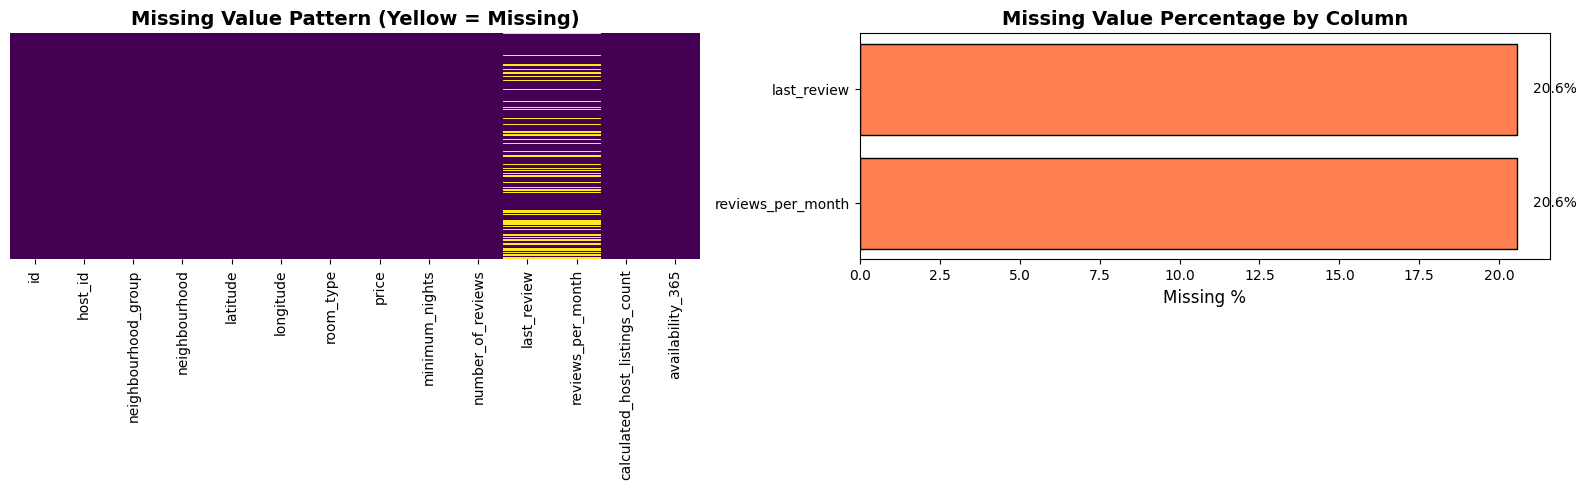


✅ Missing value analysis saved to artifacts\figures\missing_values_analysis.png

📝 Strategy: Impute after split (Step 3) using TRAIN statistics only


In [ ]:
# Missing value statistics
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Pct': missing_pct.values
}).sort_values('Missing_Count', ascending=False)

print("=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)
print(missing_df[missing_df['Missing_Count'] > 0].to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Heatmap
sns.heatmap(df_raw.isnull(), cbar=False, yticklabels=False, cmap='viridis', ax=ax1)
ax1.set_title('Missing Value Pattern (Yellow = Missing)', fontsize=14, fontweight='bold')

# Bar chart
missing_nonzero = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_nonzero) > 0:
    ax2.barh(missing_nonzero['Column'], missing_nonzero['Missing_Pct'], color='coral', edgecolor='black')
    ax2.set_xlabel('Missing %', fontsize=12)
    ax2.set_title('Missing Value Percentage by Column', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    for i, (col, pct) in enumerate(zip(missing_nonzero['Column'], missing_nonzero['Missing_Pct'])):
        ax2.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10)
else:
    ax2.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16, transform=ax2.transAxes)
    ax2.axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'missing_values_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Missing value analysis saved to {FIGURES_DIR / 'missing_values_analysis.png'}")
print(f"\n Strategy: Impute after split (Step 3) using TRAIN statistics only")


##  STEP 1: Remove Impossible Values

Only basic validation - NO STATISTICS calculated yet!


In [ ]:
df_minimal = remove_impossible_values(df_raw)
print(f"\n Step 1 complete: {len(df_minimal):,} rows ready for split")


  Removed 11 rows with price ≤ 0
  Remaining: 48,884 rows after geo filter

✅ Step 1 complete: 48,884 rows ready for split


## 5️) Exploratory Data Analysis

In [ ]:
# Quick EDA on minimally cleaned data
print("Data Summary:")
print(df_minimal.describe())
print(f"\n EDA complete - Ready for STEP 2: Split")


Data Summary:
           latitude     longitude         price  minimum_nights  \
count  48884.000000  48884.000000  48884.000000    48884.000000   
mean      40.728953    -73.952176    152.755053        7.029887   
min       40.499790    -74.244420     10.000000        1.000000   
25%       40.690100    -73.983080     69.000000        1.000000   
50%       40.723080    -73.955685    106.000000        3.000000   
75%       40.763120    -73.936290    175.000000        5.000000   
max       40.913060    -73.712990  10000.000000     1250.000000   
std        0.054532      0.046159    240.170260       20.512224   

       number_of_reviews                    last_review  reviews_per_month  \
count       48884.000000                          38833       38833.000000   
mean           23.271991  2018-10-04 01:15:09.896222208           1.373128   
min             0.000000            2011-03-28 00:00:00           0.010000   
25%             1.000000            2018-07-08 00:00:00           0.19

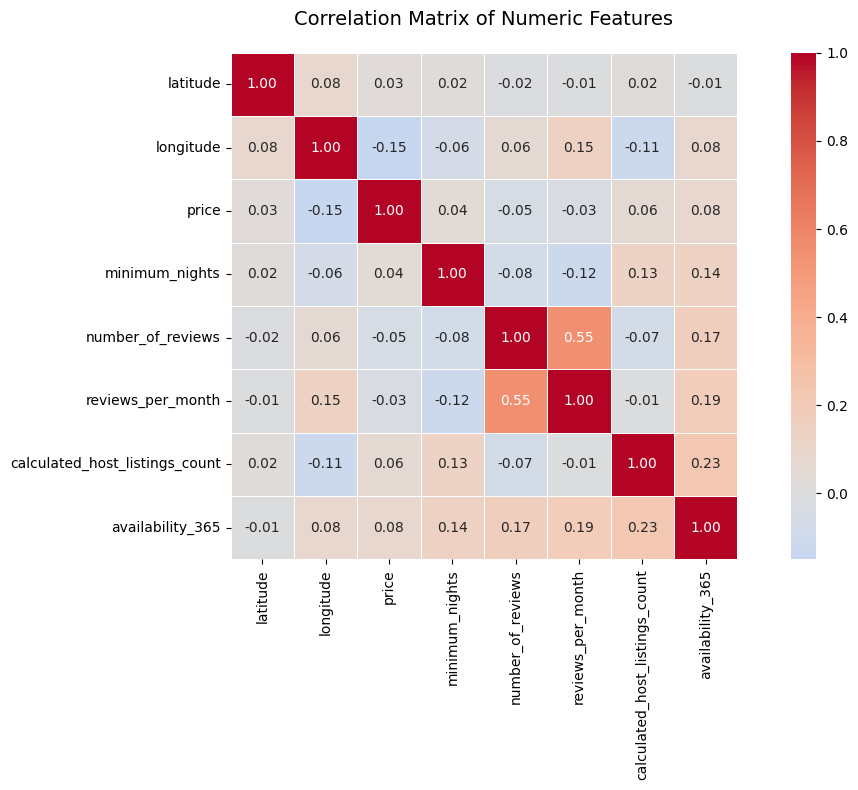


✅ Correlation analysis saved to artifacts\figures\correlation_matrix.png


In [ ]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
numeric_cols = df_minimal.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_minimal[numeric_cols].corr()

# Create heatmap
sns.heatmap(
            correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            linewidths=0.5
            )

plt.title('Correlation Matrix of Numeric Features', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Correlation analysis saved to {FIGURES_DIR / 'correlation_matrix.png'}")


##  STEP 2: Split Train/Test (EARLY!)

**CRITICAL:** Split BEFORE any statistical operations to prevent leakage!


In [ ]:
# Define feature columns
NOMINAL_COLS = [
                'neighbourhood_group', 
                'neighbourhood'
                ]
ORDINAL_COLS = ['room_type']
ORDINAL_CATEGORIES = [['Shared room', 'Private room', 'Entire home/apt']]
NUMERIC_COLS = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'calculated_host_listings_count', 'availability_365']

# Prepare X, y
feature_cols = NOMINAL_COLS + ORDINAL_COLS + NUMERIC_COLS + ['last_review', 'reviews_per_month']
X = df_minimal[feature_cols].copy()
y_price = df_minimal['price'].copy()

# SPLIT FIRST!
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y_price, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE
                                                    )

print(f" Step 2 complete:")
print(f"   TRAIN: {len(X_train):,} samples")
print(f"   TEST:  {len(X_test):,} samples")
print(f"\n NO FITTING HAS OCCURRED YET - ALL STATISTICS WILL USE TRAIN ONLY")


✅ Step 2 complete:
   TRAIN: 39,107 samples
   TEST:  9,777 samples

⚠️ NO FITTING HAS OCCURRED YET - ALL STATISTICS WILL USE TRAIN ONLY


##  STEP 3: Impute Missing Values

Fit imputers on TRAIN, apply to TEST.


In [ ]:
# Strategy: reviews_per_month based on number_of_reviews
def impute_reviews_per_month(df):
    df = df.copy()
    df.loc[df['number_of_reviews'] == 0, 'reviews_per_month'] = 0.0
    df['reviews_per_month'].fillna(df['reviews_per_month'].median(), inplace=True)
    return df

X_train = impute_reviews_per_month(X_train)
# Use TRAIN median for TEST
test_median = X_train['reviews_per_month'].median()
X_test = X_test.copy()
X_test.loc[X_test['number_of_reviews'] == 0, 'reviews_per_month'] = 0.0
X_test['reviews_per_month'].fillna(test_median, inplace=True)

print(f" Step 3 complete: Missing values imputed")
print(f"   TRAIN median used: {test_median:.2f}")


✅ Step 3 complete: Missing values imputed
   TRAIN median used: 0.37


##  STEP 4: Handle Outliers (IQR - Price Only)

Calculate IQR bounds on TRAIN, apply to both.

# ![IQR Outlier Detection](https://docs.oracle.com/en/cloud/saas/tax-reporting-cloud/ustrc/img/insights_iqr_example.jpg)

In [ ]:
# Calculate IQR on TRAIN only
price_lower, price_upper = calculate_iqr_bounds(y_train, IQR_MULTIPLIER)
print(f"IQR bounds (from TRAIN): ${price_lower:.2f} to ${price_upper:.2f}")

# Count outliers
train_outliers = ((y_train < price_lower) | (y_train > price_upper)).sum()
test_outliers = ((y_test < price_lower) | (y_test > price_upper)).sum()
print(f"Outliers detected: TRAIN={train_outliers:,}, TEST={test_outliers:,}")

# Remove outliers from TRAIN
mask_train = (y_train >= price_lower) & (y_train <= price_upper)
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Apply same bounds to TEST
mask_test = (y_test >= price_lower) & (y_test <= price_upper)
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print(f"\n Step 4 complete:")
print(f"   TRAIN: {len(X_train):,} samples")
print(f"   TEST:  {len(X_test):,} samples")


IQR bounds (from TRAIN): $-90.00 to $334.00
Outliers detected: TRAIN=2,372, TEST=600

✅ Step 4 complete:
   TRAIN: 36,735 samples
   TEST:  9,177 samples


##  STEP 5: Feature Engineering & Binning

Derive new features using TRAIN statistics only.


In [ ]:
# Feature engineering: days_since_last_review using TRAIN max
max_date_train = X_train['last_review'].max()
X_train['days_since_last_review'] = (max_date_train - X_train['last_review']).dt.days
X_train['days_since_last_review'].fillna(X_train['days_since_last_review'].max(), inplace=True)

# Apply TRAIN's max_date to TEST
X_test['days_since_last_review'] = (max_date_train - X_test['last_review']).dt.days
X_test['days_since_last_review'].fillna(X_train['days_since_last_review'].max(), inplace=True)

# Update numeric columns
NUMERIC_COLS.extend(['reviews_per_month', 'days_since_last_review'])

# Drop last_review (no longer needed)
X_train = X_train.drop(columns=['last_review'])
X_test = X_test.drop(columns=['last_review'])

print(f" Step 5 complete: Features engineered using TRAIN statistics")

✅ Step 5 complete: Features engineered using TRAIN statistics


In [ ]:
# Handle availability_365 <= 0 by imputing with median from TRAIN
train_median = X_train.loc[X_train['availability_365'] > 0, 'availability_365'].median()
X_train.loc[X_train['availability_365'] <= 0, 'availability_365'] = train_median
X_test.loc[X_test['availability_365'] <= 0, 'availability_365'] = train_median

print(f" Imputed availability_365 <= 0 with TRAIN median ({train_median:.0f})")


✅ Imputed availability_365 <= 0 with TRAIN median (163)


## 6️ Derive Classification Target

Quantiles from TRAIN only.


In [ ]:
# Compute quantiles on TRAIN
q33, q66 = y_train.quantile([0.33, 0.66])
print(f"Price quantiles (TRAIN): q33=${q33:.0f}, q66=${q66:.0f}")

# Apply to both
def binning_price(y, q33, q66):
    return pd.cut(
                y, 
                bins=[0, q33, q66, np.inf], 
                labels=['Budget', 'Standard', 'Luxury'], 
                include_lowest=True
                )

y_train_cat = binning_price(y_train, q33, q66)
y_test_cat = binning_price(y_test, q33, q66)

print(f"\nTRAIN class distribution:")
print(y_train_cat.value_counts().sort_index())
print(f"\nTEST class distribution:")
print(y_test_cat.value_counts().sort_index())

# Save thresholds
with open(ARTIFACTS_DIR / 'price_bin_thresholds.json', 'w') as f:
    json.dump({'q33': float(q33), 'q66': float(q66), 'labels': ['Budget', 'Standard', 'Luxury']}, f, indent=2)

print(f"\n Classification target derived")


Price quantiles (TRAIN): q33=$75, q66=$138

TRAIN class distribution:
price
Budget      12154
Standard    12114
Luxury      12467
Name: count, dtype: int64

TEST class distribution:
price
Budget      3082
Standard    3002
Luxury      3093
Name: count, dtype: int64

✅ Classification target derived


##  STEPS 6 & 7: Scale & Encode

Build preprocessor, fit on TRAIN, transform both.


In [ ]:
# Build preprocessor
preprocessor = build_preprocessor(NOMINAL_COLS, ORDINAL_COLS, ORDINAL_CATEGORIES, NUMERIC_COLS)

print("Fitting preprocessor on TRAIN...")
preprocessor.fit(X_train)

# Transform
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"\n Steps 6 & 7 complete:")
print(f"   TRAIN shape: {X_train_transformed.shape}")
print(f"   TEST shape:  {X_test_transformed.shape}")

# Extract feature names
feature_names = extract_feature_names(preprocessor)
print(f"   Features: {len(feature_names)}")

# Save
joblib.dump(preprocessor, ARTIFACTS_DIR / 'preprocessor.joblib')
with open(ARTIFACTS_DIR / 'feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=2)

print(f"\n Preprocessor saved")


Fitting preprocessor on TRAIN...

✅ Steps 6 & 7 complete:
   TRAIN shape: (36735, 39)
   TEST shape:  (9177, 39)
   Features: 39

✅ Preprocessor saved


## 7️ Save Artifacts

In [ ]:
# Save regression arrays
np.savez_compressed(ARTIFACTS_DIR / 'X_train_reg.npz', data=X_train_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'X_test_reg.npz', data=X_test_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'y_train_reg.npz', data=y_train.values)
np.savez_compressed(ARTIFACTS_DIR / 'y_test_reg.npz', data=y_test.values)

# Save classification arrays
np.savez_compressed(ARTIFACTS_DIR / 'X_train_cls.npz', data=X_train_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'X_test_cls.npz', data=X_test_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'y_train_cls.npz', data=y_train_cat.cat.codes.values)
np.savez_compressed(ARTIFACTS_DIR / 'y_test_cls.npz', data=y_test_cat.cat.codes.values)

print(" All artifacts saved:")
print(f"   - Preprocessor & feature names")
print(f"   - Regression arrays (TRAIN/TEST)")
print(f"   - Classification arrays (TRAIN/TEST)")
print(f"   - Price bin thresholds")


✅ All artifacts saved:
   - Preprocessor & feature names
   - Regression arrays (TRAIN/TEST)
   - Classification arrays (TRAIN/TEST)
   - Price bin thresholds


In [17]:
# Save preprocessor object
import pickle

with open(ARTIFACTS_DIR / 'preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("✅ Preprocessor object saved as pickle file")


✅ Preprocessor object saved as pickle file


## 8️ Summary

In [ ]:
print("=" * 80)
print("DATA PREPARATION COMPLETE - 7-STEP PIPELINE")
print("=" * 80)
print(f"\n TRAIN: {X_train_transformed.shape[0]:,} samples × {X_train_transformed.shape[1]} features")
print(f" TEST:  {X_test_transformed.shape[0]:,} samples × {X_test_transformed.shape[1]} features")
print(f"\n NO DATA LEAKAGE:")
print(f"   ✓ Split early (before imputation, outliers, engineering)")
print(f"   ✓ All statistics calculated on TRAIN only")
print(f"   ✓ TEST never influenced TRAIN preprocessing")
print(f"\n Ready for modeling!")


DATA PREPARATION COMPLETE - 7-STEP PIPELINE

✅ TRAIN: 36,735 samples × 39 features
✅ TEST:  9,177 samples × 39 features

🔒 NO DATA LEAKAGE:
   ✓ Split early (before imputation, outliers, engineering)
   ✓ All statistics calculated on TRAIN only
   ✓ TEST never influenced TRAIN preprocessing

✅ Ready for modeling!
